In [1]:
from ast import literal_eval
from itertools import chain

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizer, BertTokenizerFast

# Load Data

**merge dataframe** 
* literal_eval: turn string into list

In [2]:
BASE_URL = "../input/nbme-score-clinical-patient-notes"


def process_feature_text(text):
    return text.replace("-OR-", ";-").replace("-", " ")


def prepare_datasets():
    features = pd.read_csv(f"{BASE_URL}/features.csv")
    notes = pd.read_csv(f"{BASE_URL}/patient_notes.csv")
    df = pd.read_csv(f"{BASE_URL}/train.csv")
    df["annotation_list"] = [literal_eval(x) for x in df["annotation"]]
    df["location_list"] = [literal_eval(x) for x in df["location"]]

    merged = df.merge(notes, how="left")
    merged = merged.merge(features, how="left")

    merged["feature_text"] = [process_feature_text(x) for x in merged["feature_text"]]
    merged["feature_text"] = merged["feature_text"].apply(lambda x: x.lower())
    merged["pn_history"] = merged["pn_history"].apply(lambda x: x.lower())

    return merged

In [3]:
df = prepare_datasets()

In [6]:
df1=df.drop('annotation',axis=1)
df1=df1.drop('location',axis=1)

In [11]:
df1.iloc[2,:]

id                                                         00016_002
case_num                                                           0
pn_num                                                            16
feature_num                                                        2
annotation_list                                     [chest pressure]
location_list                                              [203 217]
pn_history         hpi: 17yo m presents with palpitations. patien...
feature_text                                          chest pressure
Name: 2, dtype: object

# Tokenize

* loc_list_to_ints:  loc_list(location in type:list),turn list into int
* tokenize_and_add_labels: here we can understand in QA's way. Q is feature, the frist sentence,label=0,A is named entity, in patient notes, label=1


out.sequence_ids: from sentence1, label=0,from sentence2, label=1, separate/padding, label=None. length=1000(max_length)
out["offset_mapping"]: location of each word

In [5]:
def loc_list_to_ints(loc_list):
    to_return = []
    for loc_str in loc_list:
        loc_strs = loc_str.split(";")
        for loc in loc_strs:
            start, end = loc.split()
            to_return.append((int(start), int(end)))
    return to_return


def tokenize_and_add_labels(tokenizer, data, config):
    out = tokenizer(
        data["feature_text"],
        data["pn_history"],
        truncation=config['truncation'],
        max_length=config['max_length'],
        padding=config['padding'],
        return_offsets_mapping=config['return_offsets_mapping']
    )
    labels = [0.0] * len(out["input_ids"])
    out["location_int"] = loc_list_to_ints(data["location_list"])
    out["sequence_ids"] = out.sequence_ids()

    for idx, (seq_id, offsets) in enumerate(zip(out["sequence_ids"], out["offset_mapping"])):
        if not seq_id or seq_id == 0:
            labels[idx] = -1
            continue

        token_start, token_end = offsets
        for feature_start, feature_end in out["location_int"]:
            if token_start >= feature_start and token_end <= feature_end:
                labels[idx] = 1.0
                break

    out["labels"] = labels

    return out

To see how Tokenizer works

In [6]:
first = df.iloc[0]
first

id                                                         00016_000
case_num                                                           0
pn_num                                                            16
feature_num                                                        0
annotation                          ['dad with recent heart attcak']
location                                                 ['696 724']
annotation_list                       [dad with recent heart attcak]
location_list                                              [696 724]
pn_history         hpi: 17yo m presents with palpitations. patien...
feature_text       family history of mi; family history of myocar...
Name: 0, dtype: object

In [7]:
feature_text1, pn_history1 = first.feature_text, first.pn_history
print("feature_text", feature_text1)
print("\n")
print("pn_history", pn_history1)

feature_text family history of mi; family history of myocardial infarction


pn_history hpi: 17yo m presents with palpitations. patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). of note patient endorses abusing adderall, primarily to study (1-3 times per week). before recent soccer game, took adderrall night before and morning of game. denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. 
pmhx: none
rx: uses friends adderrall
fhx: mom with "thyroid disease," dad with recent heart attcak
all: none
immunizations: up to date
shx: freshmen in college. endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. sexually active with girlfriend x 

In [8]:
tokenizer1 = BertTokenizerFast.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
tokens1 = tokenizer1.tokenize(feature_text1, pn_history1)
print("Total Tokens", len(tokens1))
print(tokens1)

Total Tokens 255
['family', 'history', 'of', 'mi', ';', 'family', 'history', 'of', 'my', '##oca', '##rdial', 'in', '##far', '##ction', 'hp', '##i', ':', '17', '##yo', 'm', 'presents', 'with', 'pal', '##pit', '##ations', '.', 'patient', 'reports', '3', '-', '4', 'months', 'of', 'intermittent', 'episodes', 'of', '"', 'heart', 'beating', '/', 'pounding', 'out', 'of', 'my', 'chest', '.', '"', '2', 'days', 'ago', 'during', 'a', 'soccer', 'game', 'had', 'an', 'episode', ',', 'but', 'this', 'time', 'had', 'chest', 'pressure', 'and', 'felt', 'as', 'if', 'he', 'were', 'going', 'to', 'pass', 'out', '(', 'did', 'not', 'lose', 'con', '##cious', '##ness', ')', '.', 'of', 'note', 'patient', 'end', '##ors', '##es', 'abu', '##sing', 'add', '##eral', '##l', ',', 'primarily', 'to', 'study', '(', '1', '-', '3', 'times', 'per', 'week', ')', '.', 'before', 'recent', 'soccer', 'game', ',', 'took', 'add', '##er', '##ral', '##l', 'night', 'before', 'and', 'morning', 'of', 'game', '.', 'denies', 'short', '##ne

'##' means they are in one word

In [10]:
out1 = tokenizer1(
        feature_text1,
        pn_history1,
        truncation=True,
        max_length=416,
        padding="max_length",
        return_offsets_mapping=True
)

In [11]:
#out1['token_type_ids']
#input_ids, attention_mask, token_type_ids, offset_mapping

# Evaluation

In [12]:
from sklearn.metrics import accuracy_score

def get_location_predictions(preds, offset_mapping, sequence_ids, test=False):
    all_predictions = []
    for pred, offsets, seq_ids in zip(preds, offset_mapping, sequence_ids):
        pred = 1 / (1 + np.exp(-pred))
        start_idx = None
        end_idx = None
        current_preds = []
        for pred, offset, seq_id in zip(pred, offsets, seq_ids):
            if seq_id is None or seq_id == 0:
                continue

            if pred > 0.5:
                if start_idx is None:
                    start_idx = offset[0]
                end_idx = offset[1]
            elif start_idx is not None:
                if test:
                    current_preds.append(f"{start_idx} {end_idx}")
                else:
                    current_preds.append((start_idx, end_idx))
                start_idx = None
        if test:
            all_predictions.append("; ".join(current_preds))
        else:
            all_predictions.append(current_preds)
            
    return all_predictions


def calculate_char_cv(predictions, offset_mapping, sequence_ids, labels):
    all_labels = []
    all_preds = []
    for preds, offsets, seq_ids, labels in zip(predictions, offset_mapping, sequence_ids, labels):

        num_chars = max(list(chain(*offsets)))
        char_labels = np.zeros(num_chars)

        for o, s_id, label in zip(offsets, seq_ids, labels):
            if s_id is None or s_id == 0:
                continue
            if int(label) == 1:
                char_labels[o[0]:o[1]] = 1

        char_preds = np.zeros(num_chars)

        for start_idx, end_idx in preds:
            char_preds[start_idx:end_idx] = 1

        all_labels.extend(char_labels)
        all_preds.extend(char_preds)

    results = precision_recall_fscore_support(all_labels, all_preds, average="binary", labels=np.unique(all_preds))
    accuracy = accuracy_score(all_labels, all_preds)
    

    return {
        "Accuracy": accuracy,
        "precision": results[0],
        "recall": results[1],
        "f1": results[2]
    }

# Dataset

In [13]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        tokens = tokenize_and_add_labels(self.tokenizer, data, self.config)

        input_ids = np.array(tokens["input_ids"])
        attention_mask = np.array(tokens["attention_mask"])
        token_type_ids = np.array(tokens["token_type_ids"])

        labels = np.array(tokens["labels"])
        offset_mapping = np.array(tokens['offset_mapping'])
        sequence_ids = np.array(tokens['sequence_ids']).astype("float16")
        
        return input_ids, attention_mask, token_type_ids, labels, offset_mapping, sequence_ids

# BERT

In [24]:
class CustomModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = AutoModel.from_pretrained(config['model_name'])  # BERT model
        self.lstm=nn.LSTM(input_size=768,hidden_size=384,batch_first=True,bidirectional=True)
        self.dropout = nn.Dropout(p=config['dropout'])
        self.config = config
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        batch_size=input_ids.size(0)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).last_hidden_state
        outputs,_=self.lstm(outputs)
        #outputs =self.dropout(outputs)  
        #outputs=outputs[:,-1,:]
        logits = self.fc1(outputs)
        #print(logits.size())
        logits = self.fc2(self.dropout(logits))
        logits = self.fc3(self.dropout(logits)).squeeze(-1)
        return logits

In [28]:
hyperparameters = {
    "max_length": 416,
    "padding": "max_length",
    "return_offsets_mapping": True,
    "truncation": "only_second",
    "model_name": "../input/huggingface-bert/bert-base-uncased",
    "dropout": 0.2,
    "lr": 1e-5,
    "test_size": 0.2,
    "seed": 1268,
    "batch_size": 8
}

In [29]:
train_df = prepare_datasets()

X_train, X_test = train_test_split(train_df, test_size=hyperparameters['test_size'],
                                   random_state=hyperparameters['seed'])


print("Train size", len(X_train))
print("Test Size", len(X_test))

Train size 11440
Test Size 2860


In [30]:
tokenizer = AutoTokenizer.from_pretrained(hyperparameters['model_name'])

training_data = CustomDataset(X_train, tokenizer, hyperparameters)
train_dataloader = DataLoader(training_data, batch_size=hyperparameters['batch_size'], shuffle=True)

test_data = CustomDataset(X_test, tokenizer, hyperparameters)
test_dataloader = DataLoader(test_data, batch_size=hyperparameters['batch_size'], shuffle=False)

# Train

In [31]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = CustomModel(hyperparameters).to(DEVICE)

criterion = torch.nn.BCEWithLogitsLoss(reduction = "none")
optimizer = optim.AdamW(model.parameters(), lr=hyperparameters['lr'])


Some weights of the model checkpoint at ../input/huggingface-bert/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
def train_model(model, dataloader, optimizer, criterion):
        model.train()
        train_loss = []

        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
            token_type_ids = batch[2].to(DEVICE)
            labels = batch[3].to(DEVICE)

            logits = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(logits, labels)
    
            loss = torch.masked_select(loss, labels > -1.0).mean()
            train_loss.append(loss.item() * input_ids.size(0))
            loss.backward()
          
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        return sum(train_loss)/len(train_loss)

In [34]:
def eval_model(model, dataloader, criterion):
        model.eval()
        valid_loss = []
        preds = []
        offsets = []
        seq_ids = []
        valid_labels = []

        for batch in tqdm(dataloader):
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
            token_type_ids = batch[2].to(DEVICE)
            labels = batch[3].to(DEVICE)
            offset_mapping = batch[4]
            sequence_ids = batch[5]

            logits = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(logits, labels)
            loss = torch.masked_select(loss, labels > -1.0).mean()
            valid_loss.append(loss.item() * input_ids.size(0))
            
            preds.append(logits.detach().cpu().numpy())
            offsets.append(offset_mapping.numpy())
            seq_ids.append(sequence_ids.numpy())
            valid_labels.append(labels.detach().cpu().numpy())

        preds = np.concatenate(preds, axis=0)
        offsets = np.concatenate(offsets, axis=0)
        seq_ids = np.concatenate(seq_ids, axis=0)
        valid_labels = np.concatenate(valid_labels, axis=0)
        location_preds = get_location_predictions(preds, offsets, seq_ids, test=False)
        score = calculate_char_cv(location_preds, offsets, seq_ids, valid_labels)

        return sum(valid_loss)/len(valid_loss), score

In [35]:
import time

train_loss_data, valid_loss_data = [], []
score_data_list = []
valid_loss_min = np.Inf
since = time.time()
epochs = 3

In [36]:
best_loss = np.inf

for i in range(epochs):
    print("Epoch: {}/{}".format(i + 1, epochs))
    # first train model
    train_loss = train_model(model, train_dataloader, optimizer, criterion)
    train_loss_data.append(train_loss)
    print(f"Train loss: {train_loss}")
    # evaluate model
    valid_loss, score = eval_model(model, test_dataloader, criterion)
    valid_loss_data.append(valid_loss)
    score_data_list.append(score)
    print(f"Valid loss: {valid_loss}")
    print(f"Valid score: {score}")
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "nbme_bert_v2.pth")

    
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.4206100618006489


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.16972102827906427
Valid score: {'Accuracy': 0.9904985148184693, 'precision': 0.6425541724296912, 'recall': 0.8057699534587922, 'f1': 0.7149654367537481}
Epoch: 2/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.1392640191830304


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.12609494374009994
Valid score: {'Accuracy': 0.9934821307951578, 'precision': 0.7643393906271349, 'recall': 0.8085739889573035, 'f1': 0.7858346912400966}
Epoch: 3/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.09764913804253766


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.12345175769279479
Valid score: {'Accuracy': 0.9927827188825826, 'precision': 0.7049836809333118, 'recall': 0.8804093313676177, 'f1': 0.7829909761678279}
Training completed in 34m 37s


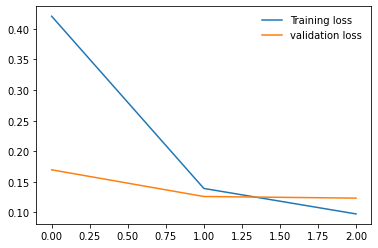

In [37]:
from matplotlib import pyplot as plt
plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

# Testing

In [ ]:
model.load_state_dict(torch.load("nbme_bert_v2.pth", map_location = DEVICE))

In [ ]:
def create_test_df():
    feats = pd.read_csv(f"{BASE_URL}/features.csv")
    notes = pd.read_csv(f"{BASE_URL}/patient_notes.csv")
    test = pd.read_csv(f"{BASE_URL}/test.csv")

    merged = test.merge(notes, how = "left")
    merged = merged.merge(feats, how = "left")

    def process_feature_text(text):
        return text.replace("-OR-", ";-").replace("-", " ")
    
    merged["feature_text"] = [process_feature_text(x) for x in merged["feature_text"]]
    
    return merged


class SubmissionDataset(Dataset):
    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data.loc[idx]
        tokenized = self.tokenizer(
            example["feature_text"],
            example["pn_history"],
            truncation = self.config['truncation'],
            max_length = self.config['max_length'],
            padding = self.config['padding'],
            return_offsets_mapping = self.config['return_offsets_mapping']
        )
        tokenized["sequence_ids"] = tokenized.sequence_ids()

        input_ids = np.array(tokenized["input_ids"])
        attention_mask = np.array(tokenized["attention_mask"])
        token_type_ids = np.array(tokenized["token_type_ids"])
        offset_mapping = np.array(tokenized["offset_mapping"])
        sequence_ids = np.array(tokenized["sequence_ids"]).astype("float16")

        return input_ids, attention_mask, token_type_ids, offset_mapping, sequence_ids


test_df = create_test_df()

submission_data = SubmissionDataset(test_df, tokenizer, hyperparameters)
submission_dataloader = DataLoader(submission_data, batch_size=hyperparameters['batch_size'], shuffle=False)


In [ ]:
model.eval()
preds = []
offsets = []
seq_ids = []

for batch in tqdm(submission_dataloader):
    input_ids = batch[0].to(DEVICE)
    attention_mask = batch[1].to(DEVICE)
    token_type_ids = batch[2].to(DEVICE)
    offset_mapping = batch[3]
    sequence_ids = batch[4]

    logits = model(input_ids, attention_mask, token_type_ids)
    
    preds.append(logits.detach().cpu().numpy())
    offsets.append(offset_mapping.numpy())
    seq_ids.append(sequence_ids.numpy())

preds = np.concatenate(preds, axis=0)
offsets = np.concatenate(offsets, axis=0)
seq_ids = np.concatenate(seq_ids, axis=0)

In [ ]:
location_preds = get_location_predictions(preds, offsets, seq_ids, test=True)

In [ ]:
len(location_preds), len(test_df)

In [ ]:
test_df["location"] = location_preds

In [ ]:
test_df[["id", "location"]].to_csv("submission.csv", index = False)
pd.read_csv("submission.csv").head()